## Source:

In [1]:
!wget -q https://raw.githubusercontent.com/sayantanauddy/vae_lightning/main/data.py 

In [2]:
%%capture
! pip install torchvision pytorch-lightning torchmetrics  torch test-tube lightning-bolts umap-learn einops

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from torch.utils.data import DataLoader, random_split

## Get the Kaggle api token and upload it to colab. Follow the instructions [here](https://github.com/Kaggle/kaggle-api#api-credentials).


In [4]:
!pip install kaggle

In [5]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [6]:
!mkdir /root/.kaggle

In [7]:
!cp kaggle.json /root/.kaggle/kaggle.json

In [8]:
!chmod 600 /root/.kaggle/kaggle.json

# MFA

In [9]:
import numpy as np
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import time
import math
import warnings
from data import CelebADataset,  CelebADataModule

class MFA(torch.nn.Module):
    """
    A class representing a Mixture of Factor Analyzers [1] / Mixture of Probabilistic PCA [2] in pytorch.
    MFA/MPPCA are Gaussian Mixture Models with low-rank-plus-diagonal covariance, enabling efficient modeling
    of high-dimensional domains in which the data resoides near lower-dimensional subspaces.
    The implementation is based on [3] (please quote this if you are using this package in your research).
    Attributes (model parameters):
    ------------------------------
    MU: Tensor shaped [n_components, n_features]
        The component means.
    A: Tensor shaped [n_components, n_features, n_factors]
        The component subspace directions / factor loadings. These should be orthogonal (but not orthonormal)
    lod_D: Tensor shaped [n_components, n_features]
        Log of the component diagonal variance values. Note that in MPPCA, all values along the diagonal are the same.
    PI_logits: Tensor shaped [n_components]
        Log of the component mixing-coefficients (probabilities). Apply softmax to get the actual PI values.
    Main Methods:
    -------------
    fit:
        Fit the MPPCA model parameters to pre-loaded training data using EM
    batch_fit:
        Fit the MPPCA model parameters to a (possibly large) pytorch dataset using EM in batches
    sample:
        Generate new samples from the trained model
    per_component_log_likelihood, log_prob, log_likelihood:
        Probability query methods
    responsibilities, log_responsibilities, map_component:
        Responsibility (which component the sample comes from) query methods
    reconstruct, conditional_reconstruct:
        Reconstruction and in-painting
    [1] Tipping, Michael E., and Christopher M. Bishop. "Mixtures of probabilistic principal component analyzers."
        Neural computation 11.2 (1999): 443-482.
    [2] Ghahramani, Zoubin, and Geoffrey E. Hinton. "The EM algorithm for mixtures of factor analyzers."
        Vol. 60. Technical Report CRG-TR-96-1, University of Toronto, 1996.
    [3] Richardson, Eitan, and Yair Weiss. "On gans and gmms."
        Advances in Neural Information Processing Systems. 2018.
    """
    def __init__(self, n_components, n_features, n_factors, isotropic_noise=True, init_method='rnd_samples'):
        super(MFA, self).__init__()
        self.n_components = n_components
        self.n_features = n_features
        self.n_factors = n_factors
        self.init_method = init_method
        self.isotropic_noise = isotropic_noise

        self.MU = torch.nn.Parameter(torch.zeros(n_components, n_features), requires_grad=False)
        self.A = torch.nn.Parameter(torch.zeros(n_components, n_features, n_factors), requires_grad=False)
        self.log_D = torch.nn.Parameter(torch.zeros(n_components, n_features), requires_grad=False)
        self.PI_logits = torch.nn.Parameter(torch.log(torch.ones(n_components)/float(n_components)), requires_grad=False)

    def sample(self, n, with_noise=False):
        """
        Generate random samples from the trained MFA / MPPCA
        :param n: How many samples
        :param with_noise: Add the isotropic / diagonal noise to the generated samples
        :return: samples [n, n_features], c_nums - originating component numbers
        """
        if torch.all(self.A == 0.):
            warnings.warn('SGD MFA training requires initialization. Please call batch_fit() first.')

        K, d, l = self.A.shape
        c_nums = np.random.choice(K, n, p=torch.softmax(self.PI_logits, dim=0).detach().cpu().numpy())
        z_l = torch.randn(n, l, device=self.A.device)
        z_d = torch.randn(n, d, device=self.A.device) if with_noise else torch.zeros(n, d, device=self.A.device)
        samples = torch.stack([self.A[c_nums[i]] @ z_l[i] + self.MU[c_nums[i]] + z_d[i] * torch.exp(0.5*self.log_D[c_nums[i]])
                               for i in range(n)])
        return samples, c_nums

    @staticmethod
    def _component_log_likelihood(x, PI, MU, A, log_D):
        K, d, l = A.shape
        AT = A.transpose(1, 2)
        iD = torch.exp(-log_D).view(K, d, 1)
        L = torch.eye(l, device=A.device).reshape(1, l, l) + AT @ (iD*A)
        iL = torch.inverse(L)

        def per_component_md(i):
            x_c = (x - MU[i].reshape(1, d)).T  # shape = (d, n)
            m_d_1 = (iD[i] * x_c) - ((iD[i] * A[i]) @ iL[i]) @ (AT[i] @ (iD[i] * x_c))
            return torch.sum(x_c * m_d_1, dim=0)

        m_d = torch.stack([per_component_md(i) for i in range(K)])
        det_L = torch.logdet(L)
        log_det_Sigma = det_L - torch.sum(torch.log(iD.reshape(K, d)), axis=1)
        log_prob_data_given_components = -0.5 * ((d*np.log(2.0*math.pi) + log_det_Sigma).reshape(K, 1) + m_d)
        return PI.reshape(1, K) + log_prob_data_given_components.T

    def per_component_log_likelihood(self, x, sampled_features=None):
        """
        Calculate per-sample and per-component log-likelihood values
        :param x: samples [n, n_features]
        :param sampled_features: list of feature coordinates to use
        :return: log-probability values [n, n_components]
        """
        if sampled_features is not None:
            return MFA._component_log_likelihood(x[:, sampled_features], torch.softmax(self.PI_logits, dim=0),
                                                 self.MU[:, sampled_features],
                                                 self.A[:, sampled_features],
                                                 self.log_D[:, sampled_features])
        return MFA._component_log_likelihood(x, torch.softmax(self.PI_logits, dim=0), self.MU, self.A, self.log_D)

    def log_prob(self, x, sampled_features=None):
        """
        Calculate per-sample log-probability values
        :param x: samples [n, n_features]
        :param sampled_features: list of feature coordinates to use
        :return: log-probability values [n]
        """
        return torch.logsumexp(self.per_component_log_likelihood(x, sampled_features), dim=1)

    def log_likelihood(self, x, sampled_features=None):
        """
        Calculate the log-likelihood of the given data
        :param x: samples [n, n_features]
        :param sampled_features: list of feature coordinates to use
        :return: (total) log-likelihood value
        """
        return torch.sum(self.log_prob(x, sampled_features))

    def log_responsibilities(self, x, sampled_features=None):
        """
        Calculate the log-responsibilities (log of the responsibility values - probability of each sample to originate
        from each of the component.
        :param x: samples [n, n_features]
        :param sampled_features: list of feature coordinates to use
        :return: log-responsibilities values [n, n_components]
        """
        comp_LLs = self.per_component_log_likelihood(x, sampled_features)
        return comp_LLs - torch.logsumexp(comp_LLs, dim=1).reshape(-1, 1)

    def responsibilities(self, x, sampled_features=None):
        """
        Calculate the responsibilities - probability of each sample to originate from each of the component.
        :param x: samples [n, n_features]
        :param sampled_features: list of feature coordinates to use
        :return: responsibility values [n, n_components]
        """
        return torch.exp(self.log_responsibilities(x, sampled_features))

    def map_component(self, x, sampled_features=None):
        """
        Get the Maximum a Posteriori component numbers
        :param x: samples [n, n_features]
        :param sampled_features: list of feature coordinates to use
        :return: component numbers [n]
        """
        return torch.argmax(self.log_responsibilities(x, sampled_features), dim=1)

    def conditional_reconstruct(self, full_x, observed_features):
        """
        Calculates the mean of the conditional probability P(x_h | x_o)
        References:
        https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf#subsubsection.8.1.3
        https://en.wikipedia.org/wiki/Woodbury_matrix_identity
        Note: This is equivalent to calling reconstruct with sampled_features
        :param full_x: the full vectors (including the hidden coordinates, which can contain any values)
        :param observed_features: tensor containing a list of the observed coordinates of x
        :return: A cloned version of full_x with the hidden features reconstructed
        """
        assert observed_features is not None
        K, d, l = self.A.shape
        c_i = self.map_component(full_x, observed_features)

        mask = torch.zeros(d, dtype=bool)
        mask[observed_features] = True

        A_a = self.A[c_i][:, ~mask, :]
        A_b = self.A[c_i][:, mask, :]
        MU_a = self.MU[c_i][:, ~mask]
        MU_b = self.MU[c_i][:, mask]
        iD_b = torch.exp(-self.log_D[c_i][:, mask]).unsqueeze(2)

        iL_b = torch.inverse(torch.eye(l, device=MU_b.device).reshape(1, l, l) + A_b.transpose(1, 2) @ (iD_b*A_b))
        x_b_l = ((A_b * iD_b).transpose(1,2) @ (full_x[:, mask] - MU_b).unsqueeze(2))
        x_hat = full_x.clone()
        x_hat[:, ~mask] =  (MU_a.unsqueeze(2) + A_a @ x_b_l - A_a @ (A_b.transpose(1, 2) @
                                                                     (iD_b * (A_b @ iL_b @ x_b_l)))).squeeze(dim=2)
        return x_hat

    def reconstruct(self, full_x, observed_features=None):
        """
        Reconstruct samples from the model - find the MAP component and latent z for each sample and regenerate
        :param full_x: the full vectors (including the hidden coordinates, which can contain any values)
        :param observed_features: tensor containing a list of the observed coordinates of x
        :return: Reconstruction of full_x based on the trained model and observed features
        """
        K, d, l = self.A.shape
        c_i = self.map_component(full_x, observed_features)

        used_features = observed_features if observed_features is not None else torch.arange(0, d)
        x = full_x[:, used_features]
        MU = self.MU[:, used_features]
        A = self.A[:, used_features]
        AT = A.transpose(1, 2)
        iD = torch.exp(-self.log_D[:, used_features]).unsqueeze(2)
        L = torch.eye(l, device=MU.device).reshape(1, l, l) + AT @ (iD*A)
        iL = torch.inverse(L)

        # per eq. 2 in Ghahramani and Hinton 1996 + the matrix inversion lemma (also described there).
        x_c = (x - MU[c_i]).unsqueeze(2)
        iD_c = iD[c_i]
        m_d_1 = (iD_c * x_c) - ((iD_c * A[c_i]) @ iL[c_i]) @ (AT[c_i] @ (iD_c * x_c))
        mu_z = AT[c_i] @ m_d_1
        return (self.A[c_i] @ mu_z).reshape(-1, d) + self.MU[c_i]

    @staticmethod
    def _small_sample_ppca(x, n_factors):
        # See https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca
        mu = torch.mean(x, dim=0)
        # U, S, V = torch.svd(x - mu.reshape(1, -1))    # torch svd is less memory-efficient
        U, S, V = np.linalg.svd((x - mu.reshape(1, -1)).cpu().numpy(), full_matrices=False)
        V = torch.from_numpy(V.T).to(x.device)
        S = torch.from_numpy(S).to(x.device)
        sigma_squared = torch.sum(torch.pow(S[n_factors:], 2.0))/((x.shape[0]-1) * (x.shape[1]-n_factors))
        A = V[:, :n_factors] * torch.sqrt((torch.pow(S[:n_factors], 2.0).reshape(1, n_factors)/(x.shape[0]-1) - sigma_squared))
        return mu, A, torch.log(sigma_squared) * torch.ones(x.shape[1], device=x.device)

    def _init_from_data(self, x, samples_per_component, feature_sampling=False):
        n = x.shape[0]
        K, d, l = self.A.shape

        if self.init_method == 'kmeans':
            # Import this only if 'kmeans' method was selected (not sure this is a good practice...)
            from sklearn.cluster import KMeans
            sampled_features = np.random.choice(d, int(d*feature_sampling)) if feature_sampling else np.arange(d)

            t = time.time()
            print('Performing K-means clustering of {} samples in dimension {} to {} clusters...'.format(
                x.shape[0], sampled_features.size, K))
            _x = x[:, sampled_features].cpu().numpy()
            clusters = KMeans(n_clusters=K, max_iter=300, n_jobs=-1).fit(_x)
            print('... took {} sec'.format(time.time() - t))
            component_samples = [clusters.labels_ == i for i in range(K)]
        elif self.init_method == 'rnd_samples':
            m = samples_per_component
            o = np.random.choice(n, m*K, replace=False) if m*K < n else np.arange(n)
            assert n >= m*K
            component_samples = [[o[i*m:(i+1)*m]] for i in range(K)]

        params = [torch.stack(t) for t in zip(
            *[MFA._small_sample_ppca(x[component_samples[i]], n_factors=l) for i in range(K)])]

        self.MU.data = params[0]
        self.A.data = params[1]
        self.log_D.data = params[2]

    def _parameters_sanity_check(self):
        K, d, l = self.A.shape
        assert torch.all(torch.softmax(self.PI_logits, dim=0) > 0.01/K), self.PI_logits
        assert torch.all(torch.exp(self.log_D) > 1e-5) and torch.all(torch.exp(self.log_D) < 1.0), \
            '{} - {}'.format(torch.min(self.log_D).item(), torch.max(self.log_D).item())
        assert torch.all(torch.abs(self.A) < 10.0), torch.max(torch.abs(self.A))
        assert torch.all(torch.abs(self.MU) < 1.0), torch.max(torch.abs(self.MU))

    def fit(self, x, max_iterations=20, feature_sampling=False):
        """
        Estimate Maximum Likelihood MPPCA parameters for the provided data using EM per
        Tipping, and Bishop. Mixtures of probabilistic principal component analyzers.
        :param x: training data (arranged in rows), shape = (<numbr of samples>, n_features)
        :param max_iterations: number of iterations
        :param feature_sampling: allows faster responsibility calculation by sampling data coordinates
        """
        assert self.isotropic_noise, 'EM fitting is currently supported for isotropic noise (MPPCA) only'
        assert not feature_sampling or type(feature_sampling) == float, 'set to desired sampling ratio'
        K, d, l = self.A.shape
        N = x.shape[0]

        print('Random init...')
        init_samples_per_component = (l+1)*2 if self.init_method == 'rnd_samples' else (l+1)*10
        self._init_from_data(x, samples_per_component=init_samples_per_component,
                             feature_sampling=feature_sampling/2 if feature_sampling else False)
        print('Init log-likelihood =', round(torch.mean(self.log_prob(x)).item(), 1))

        def per_component_m_step(i):
            mu_i = torch.sum(r[:, [i]] * x, dim=0) / r_sum[i]
            s2_I = torch.exp(self.log_D[i, 0]) * torch.eye(l, device=x.device)
            inv_M_i = torch.inverse(self.A[i].T @ self.A[i] + s2_I)
            x_c = x - mu_i.reshape(1, d)
            SiAi = (1.0/r_sum[i]) * (r[:, [i]]*x_c).T @ (x_c @ self.A[i])
            invM_AT_Si_Ai = inv_M_i @ self.A[i].T @ SiAi
            A_i_new = SiAi @ torch.inverse(s2_I + invM_AT_Si_Ai)
            t1 = torch.trace(A_i_new.T @ (SiAi @ inv_M_i))
            trace_S_i = torch.sum(N/r_sum[i] * torch.mean(r[:, [i]]*x_c*x_c, dim=0))
            sigma_2_new = (trace_S_i - t1)/d
            return mu_i, A_i_new, torch.log(sigma_2_new) * torch.ones_like(self.log_D[i])

        for it in range(max_iterations):
            t = time.time()
            sampled_features = np.random.choice(d, int(d*feature_sampling)) if feature_sampling else None
            r = self.responsibilities(x, sampled_features=sampled_features)
            r_sum = torch.sum(r, dim=0)
            new_params = [torch.stack(t) for t in zip(*[per_component_m_step(i) for i in range(K)])]
            self.MU.data = new_params[0]
            self.A.data = new_params[1]
            self.log_D.data = new_params[2]
            self.PI_logits.data = torch.log(r_sum / torch.sum(r_sum))
            ll = round(torch.mean(self.log_prob(x)).item(), 1) if it % 5 == 0 else '.....'
            print('Iteration {}/{}, train log-likelihood = {}, took {:.1f} sec'.format(it, max_iterations, ll,
                                                                                   time.time()-t))

    def batch_fit(self, train_dataset, test_dataset=None, batch_size=1000, test_size=1000, max_iterations=20,
                  feature_sampling=False):
        """
        Estimate Maximum Likelihood MPPCA parameters for the provided data using EM per
        Tipping, and Bishop. Mixtures of probabilistic principal component analyzers.
        Memory-efficient batched implementation for large datasets that do not fit in memory:
        E step:
            For all mini-batches:
            - Calculate and store responsibilities
            - Accumulate sufficient statistics
        M step: 
            Re-calculate all parameters
        Note that incremental EM per Neal & Hinton, 1998 is not supported, since we can't maintain
            the full x x^T as sufficient statistic - we need to multiply by A to get a more compact
            representation.
        :param train_dataset: pytorch Dataset object containing the training data (will be iterated over)
        :param test_dataset: optional pytorch Dataset object containing the test data (otherwise train_daset will be used)
        :param batch_size: the batch size
        :param test_size: number of samples to use when reporting likelihood
        :param max_iterations: number of iterations (=epochs)
        :param feature_sampling: allows faster responsibility calculation by sampling data coordinates
       """
        assert self.isotropic_noise, 'EM fitting is currently supported for isotropic noise (MPPCA) only'
        assert not feature_sampling or type(feature_sampling) == float, 'set to desired sampling ratio'
        K, d, l = self.A.shape

        init_samples_per_component = (l+1)*2 if self.init_method == 'rnd_samples' else (l+1)*10
        print('Random init using {} with {} samples per component...'.format(self.init_method, init_samples_per_component))
        init_keys = [key for i, key in enumerate(RandomSampler(train_dataset)) if i < init_samples_per_component*K]
        init_samples, _ = zip(*[train_dataset[key] for key in init_keys])
        self._init_from_data(torch.stack(init_samples).to(self.MU.device),
                             samples_per_component=init_samples_per_component,
                             feature_sampling=feature_sampling/2 if feature_sampling else False)

        # Read some test samples for test likelihood calculation
        # test_samples, _ = zip(*[test_dataset[key] for key in RandomSampler(test_dataset, num_samples=test_size, replacement=True)])
        test_dataset = test_dataset or train_dataset
        all_test_keys = [key for key in SequentialSampler(test_dataset)]
        test_samples, _ = zip(*[test_dataset[key] for key in all_test_keys[:test_size]])
        test_samples = torch.stack(test_samples).to(self.MU.device)

        ll_log = []
        loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
        for it in range(max_iterations):
            t = time.time()

            # Sufficient statistics
            sum_r = torch.zeros(size=[K], dtype=torch.float64, device=self.MU.device)
            sum_r_x = torch.zeros(size=[K, d], dtype=torch.float64, device=self.MU.device)
            sum_r_x_x_A = torch.zeros(size=[K, d, l], dtype=torch.float64, device=self.MU.device)
            sum_r_norm_x = torch.zeros(K, dtype=torch.float64, device=self.MU.device)

            ll_log.append(torch.mean(self.log_prob(test_samples)).item())
            print('Iteration {}/{}, log-likelihood={}:'.format(it, max_iterations, ll_log[-1]))

            for batch_x, _ in loader:
                print('E', end='', flush=True)
                batch_x = batch_x.to(self.MU.device)
                sampled_features = np.random.choice(d, int(d*feature_sampling)) if feature_sampling else None
                batch_r = self.responsibilities(batch_x, sampled_features=sampled_features)
                sum_r += torch.sum(batch_r, dim=0).double()
                sum_r_norm_x += torch.sum(batch_r * torch.sum(torch.pow(batch_x, 2.0), dim=1, keepdim=True), dim=0).double()
                for i in range(K):
                    batch_r_x = batch_r[:, [i]] * batch_x
                    sum_r_x[i] += torch.sum(batch_r_x, dim=0).double()
                    sum_r_x_x_A[i] += (batch_r_x.T @ (batch_x @ self.A[i])).double()

            print(' / M...', end='', flush=True)
            self.PI_logits.data = torch.log(sum_r / torch.sum(sum_r)).float()
            self.MU.data = (sum_r_x / sum_r.reshape(-1, 1)).float()
            SA = sum_r_x_x_A / sum_r.reshape(-1, 1, 1) - \
                 (self.MU.reshape(K, d, 1) @ (self.MU.reshape(K, 1, d) @ self.A)).double()
            s2_I = torch.exp(self.log_D[:, 0]).reshape(K, 1, 1) * torch.eye(l, device=self.MU.device).reshape(1, l, l)
            M = (self.A.transpose(1, 2) @ self.A + s2_I).double()
            inv_M = torch.stack([torch.inverse(M[i]) for i in range(K)])   # (K, l, l)
            invM_AT_S_A = inv_M @ self.A.double().transpose(1, 2) @ SA   # (K, l, l)
            self.A.data = torch.stack([(SA[i] @ torch.inverse(s2_I[i].double() + invM_AT_S_A[i])).float()
                                       for i in range(K)])
            t1 = torch.stack([torch.trace(self.A[i].double().T @ (SA[i] @ inv_M[i])) for i in range(K)])
            t_s = sum_r_norm_x / sum_r - torch.sum(torch.pow(self.MU, 2.0), dim=1).double()
            self.log_D.data = torch.log((t_s - t1)/d).float().reshape(-1, 1) * torch.ones_like(self.log_D)

            self._parameters_sanity_check()
            print(' ({} sec)'.format(time.time()-t))

        ll_log.append(torch.mean(self.log_prob(test_samples)).item())
        print('\nFinal train log-likelihood={}:'.format(ll_log[-1]))
        return ll_log

    def sgd_mfa_train(self, train_dataset, test_dataset=None, batch_size=128, test_size=1000, max_epochs=10,
                      learning_rate=0.001, feature_sampling=False):
        """
        Stochastic Gradient Descent training of MFA (after initialization using MPPCA EM)
        :param train_dataset: pytorch Dataset object containing the training data (will be iterated over)
        :param test_dataset: optional pytorch Dataset object containing the test data (otherwise train_daset will be used)
        :param batch_size: the batch size
        :param test_size: number of samples to use when reporting likelihood
        :param max_epochs: number of epochs
        :param feature_sampling: allows faster responsibility calculation by sampling data coordinates
        """
        if torch.all(self.A == 0.):
            warnings.warn('SGD MFA training requires initialization. Please call batch_fit() first.')
        if self.isotropic_noise:
            warnings.warn('Currently, SGD training uses diagonal (non-isotropic) noise covariance i.e. MFA and not MPPCA')
        assert not feature_sampling or type(feature_sampling) == float, 'set to desired sampling ratio'
        # self.PI_logits.requires_grad =
        self.MU.requires_grad = self.A.requires_grad = self.log_D.requires_grad = True
        K, d, l = self.A.shape

        # Read some test samples for test likelihood calculation
        # test_samples, _ = zip(*[test_dataset[key] for key in RandomSampler(test_dataset, num_samples=test_size, replacement=True)])
        test_dataset = test_dataset or train_dataset
        all_test_keys = [key for key in SequentialSampler(test_dataset)]
        test_samples, _ = zip(*[test_dataset[key] for key in all_test_keys[:test_size]])
        test_samples = torch.stack(test_samples).to(self.MU.device)

        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
        ll_log = []
        self.train()
        for epoch in range(max_epochs):
            t = time.time()
            for idx, (batch_x, _) in enumerate(loader):
                print('.', end='', flush=True)
                if idx > 0 and idx%100 == 0:
                    print(torch.mean(self.log_prob(test_samples)).item())
                sampled_features = np.random.choice(d, int(d*feature_sampling)) if feature_sampling else None
                batch_x = batch_x.to(self.MU.device)
                optimizer.zero_grad()
                loss = -self.log_likelihood(batch_x, sampled_features=sampled_features) / batch_size
                loss.backward()
                optimizer.step()
            ll_log.append(torch.mean(self.log_prob(test_samples)).item())
            print('\nEpoch {}: Test ll = {} ({} sec)'.format(epoch, ll_log[-1], time.time()-t))
            self._parameters_sanity_check()
        self.PI_logits.requires_grad = self.MU.requires_grad = self.A.requires_grad = self.log_D.requires_grad = False
        return ll_log

# Utils

In [10]:
import torch
import numpy as np
#from mfa import MFA

class ReshapeTransform:
    def __init__(self, new_size):
        self.new_size = new_size

    def __call__(self, img):
        return torch.reshape(img, self.new_size)


class CropTransform:
    def __init__(self, bbox):
        self.bbox = bbox

    def __call__(self, img):
        return img.crop(self.bbox)


def samples_to_np_images(samples, image_shape=[64, 64, 3], clamp=True):
    assert len(samples.shape) == 2
    assert samples.shape[1] == np.prod(image_shape)
    assert len(image_shape) == 2 or (len(image_shape) == 3 and image_shape[2] > 1)
    samples_out = samples if not clamp else torch.clamp(samples, 0., 1.)
    if len(image_shape) == 3:
        return samples_out.reshape(-1, image_shape[2], image_shape[0], image_shape[1]).permute(0, 2, 3, 1).cpu().numpy()
    else:
        return samples_out.reshape(-1, image_shape[0], image_shape[1]).cpu().numpy()


def sample_to_np_image(sample, image_shape=[64, 64, 3]):
    return samples_to_np_images(sample.unsqueeze(0), image_shape).squeeze()


def samples_to_mosaic(samples, image_shape=[64, 64, 3]):
    images = samples_to_np_images(samples, image_shape)
    num_images = images.shape[0]
    num_cols = int(np.ceil(np.sqrt(num_images)))
    rows = []
    for i in range(num_images // num_cols):
        rows.append(np.hstack([images[j] for j in range(i*num_cols, (i+1)*num_cols)]))
    return np.vstack(rows)


def visualize_model(model: MFA, image_shape=[64, 64, 3], start_component=0, end_component=None):
    assert len(image_shape) == 2 or (len(image_shape) == 3 and image_shape[2] > 1)
    K, d, l = model.A.shape
    h, w = image_shape[:2]
    spacer = min(8, w//8)
    end_component = end_component or min(K, 2048//(w*3+2+spacer))
    k = end_component - start_component
    z = 1.5

    def to_im(x):
        return sample_to_np_image(x, image_shape=image_shape)

    if len(image_shape) == 3:
        canvas = np.ones([(l+1)*(h+1), k*(w*3+2) + (k-1)*spacer, image_shape[2]])
    else:
        canvas = np.ones([(l+1)*(h+1), k*(w*3+2) + (k-1)*spacer])
    for c_num in range(start_component, end_component):
        x_start = (c_num-start_component)*(w*3+2+spacer)

        mu = model.MU[c_num]
        canvas[:h, x_start+w//2:x_start+w//2+w] = to_im(mu)

        D = torch.exp(0.5*model.log_D[c_num])
        canvas[:h, x_start+w//2+w+2:x_start+w//2+2*w+2] = to_im(D / torch.max(D))

        for i in range(l):
            y_start = (i+1)*(h+1)
            A_i = model.A[c_num, :, i]
            canvas[y_start:y_start+h, x_start:x_start+w] = to_im(mu + z * A_i)
            canvas[y_start:y_start+h, x_start+w+1:x_start+2*w+1] = to_im(0.5 + z * A_i)
            canvas[y_start:y_start+h, x_start+2*w+2:x_start+3*w+2] = to_im(mu - z * A_i)
    return canvas

# Train and saving the checkpoint

Preparing dataset and parameters for celeba ...


  0%|          | 0.00/1.33G [00:00<?, ?B/s]

100%|██████████| 1.33G/1.33G [00:32<00:00, 44.3MB/s]


100%|██████████| 2.02M/2.02M [00:00<00:00, 124MB/s]


100%|██████████| 1.54M/1.54M [00:00<00:00, 79.4MB/s]


100%|██████████| 466k/466k [00:00<00:00, 58.4MB/s]


100%|██████████| 2.07M/2.07M [00:00<00:00, 128MB/s]


Done!



/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


Files exist already
Defining the MFA model...
EM fitting: 300 components / 10 factors / batch size 1000 ...
Random init using rnd_samples with 22 samples per component...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Iteration 0/30, log-likelihood=4828.62890625:
EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE / M... (290.27979826927185 sec)
Iteration 1/30, log-likelihood=8927.556640625:
EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE / M... (290.18236541748047 sec)
Iteration 2/30, log-likelihood=9207.1259765625:
EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE / M... (287.925008058548 sec)
Iteration 3/30, log-likelihood=9325.5283203125:
EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE / M... (287.44399070739746 sec)
Iteration 4/30, log-likelihoo

Visualizing the trained model...


Generating random samples...
Plotting test log-likelihood graph...
Done


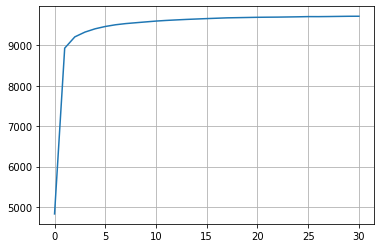

In [11]:
import sys, os
import torch
from torchvision.datasets import CelebA, MNIST
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt
from imageio import imwrite
from packaging import version

"""
MFA model training (data fitting) example.
Note that actual EM (and SGD) training code are part of the MFA class itself.
"""

def main(argv):
    assert version.parse(torch.__version__) >= version.parse('1.2.0')

    dataset = argv[1] if len(argv) == 2 else 'celeba'
    print('Preparing dataset and parameters for', dataset, '...')

    if dataset == 'celeba':
        image_shape = [64, 64, 3]       # The input image shape
        n_components = 300              # Number of components in the mixture model
        n_factors = 10                  # Number of factors - the latent dimension (same for all components)
        batch_size = 1000               # The EM batch size
        num_iterations = 30             # Number of EM iterations (=epochs)
        feature_sampling = 0.2          # For faster responsibilities calculation, randomly sample the coordinates (or False)
        mfa_sgd_epochs = 0              # Perform additional training with diagonal (per-pixel) covariance, using SGD
        init_method = 'rnd_samples'     # Initialize each component from few random samples using PPCA
        trans = transforms.Compose([CropTransform((25, 50, 25+128, 50+128)), transforms.Resize(image_shape[0]), transforms.ToTensor(),  ReshapeTransform([-1])])
        train_set = CelebADataset(root='kaggle', split='train', transform=trans, download=True) 
        test_set = CelebADataset(root='kaggle', split='test', transform=trans, download=True) 
    elif dataset == 'mnist':
        image_shape = [28, 28]          # The input image shape
        n_components = 50               # Number of components in the mixture model
        n_factors = 6                   # Number of factors - the latent dimension (same for all components)
        batch_size = 1000               # The EM batch size
        num_iterations = 30             # Number of EM iterations (=epochs)
        feature_sampling = False        # For faster responsibilities calculation, randomly sample the coordinates (or False)
        mfa_sgd_epochs = 0              # Perform additional training with diagonal (per-pixel) covariance, using SGD
        init_method = 'kmeans'          # Initialize by using k-means clustering
        trans = transforms.Compose([transforms.ToTensor(),  ReshapeTransform([-1])])
        train_set = MNIST(root='./data', train=True, transform=trans, download=True)
        test_set = MNIST(root='./data', train=False, transform=trans, download=True)
    else:
        assert False, 'Unknown dataset: ' + dataset

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model_dir = './models/'+dataset
    os.makedirs(model_dir, exist_ok=True)
    figures_dir = './figures/'+dataset
    os.makedirs(figures_dir, exist_ok=True)
    model_name = 'c_{}_l_{}_init_{}'.format(n_components, n_factors, init_method)

    print('Defining the MFA model...')
    model = MFA(n_components=n_components, n_features=np.prod(image_shape), n_factors=n_factors,
                init_method=init_method).to(device=device)

    print('EM fitting: {} components / {} factors / batch size {} ...'.format(n_components, n_factors, batch_size))
    ll_log = model.batch_fit(train_set, test_set, batch_size=batch_size, max_iterations=num_iterations,
                             feature_sampling=feature_sampling)

    if mfa_sgd_epochs > 0:
        print('Continuing training using SGD with diagonal (instead of isotropic) noise covariance...')
        model.isotropic_noise = False
        ll_log_sgd = model.sgd_mfa_train(train_set, test_size=256, max_epochs=mfa_sgd_epochs,
                                         feature_sampling=feature_sampling)
        ll_log += ll_log_sgd

    print('Saving the model...')
    torch.save(model.state_dict(), os.path.join(model_dir, 'model_'+model_name+'.pth'))

    print('Visualizing the trained model...')
    model_image = visualize_model(model, image_shape=image_shape, end_component=10)
    imwrite(os.path.join(figures_dir, 'model_'+model_name+'.jpg'), model_image)

    print('Generating random samples...')
    rnd_samples, _ = model.sample(100, with_noise=False)
    mosaic = samples_to_mosaic(rnd_samples, image_shape=image_shape)
    imwrite(os.path.join(figures_dir, 'samples_'+model_name+'.jpg'), mosaic)

    print('Plotting test log-likelihood graph...')
    plt.plot(ll_log, label='c{}_l{}_b{}'.format(n_components, n_factors, batch_size))
    plt.grid(True)
    plt.savefig(os.path.join(figures_dir, 'training_graph_'+model_name+'.jpg'))
    print('Done')

if __name__ == "__main__":
    main(sys.argv)